In [1]:
#-----import packages-----#

#common python packages
import numpy as np
import string
import random
import os
import pickle
import argparse
import wget
import math
import gc
import sys
import multiprocessing as mp

#biological packages
import pybedtools
from pybedtools import featurefuncs
import pyBigWig

#machine learning packages
import sklearn
from sklearn.utils import shuffle
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
from scipy.stats import f_oneway
from scipy.stats import ttest_ind

%matplotlib inline

In [2]:
#parsing command line arguments
# -----parsing command line arguments-----#
parser = argparse.ArgumentParser(description='Training CNN model to predict STARR-seq enhancers based on chromatin accessbility and histone marks')
parser.add_argument('-w', '--cell_types', type=str, help='comma separated string of cell_types')
parser.add_argument('-x', '--in_dir', type=str, help='input_directory')
parser.add_argument('-y', '--cell_name', type=str, help='name of the cell')
parser.add_argument('-z', '--out_dir', type=str, help='output_directory')
parser.add_argument('-a', '--track1_peaks', type=str, help='chromatin accessibility peak')
parser.add_argument('-b', '--track2_peaks', type=str, help='ChIP-seq H3K27ac peak')
parser.add_argument('-c', '--track3_peaks', type=str, help='ChIP-seq H3K4me3 peak')
parser.add_argument('-d', '--track4_peaks', type=str, help='ChIP-seq H3K9ac peak')
parser.add_argument('-e', '--track5_peaks', type=str, help='ChIP-seq H3K4me1 peak')
parser.add_argument('-f', '--track1_bw', type=str, help='chromatin accessibility bigWig')
parser.add_argument('-g', '--track2_bw', type=str, help='ChIP-seq H3K27ac bigWig')
parser.add_argument('-i', '--track3_bw', type=str, help='ChIP-seq H3K4me3 bigWig')
parser.add_argument('-j', '--track4_bw', type=str, help='ChIP-seq H3K9ac bigWig')
parser.add_argument('-k', '--track5_bw', type=str, help='ChIP-seq H3K4me1 bigWig')

cell_type = "NPC"

#simulate command line input
seqdir = "./encode/datasets/" + cell_type + "/"
cmdline_str='-w ' + " HepG2,K562,A549,HCT116,MCF-7 " + \
    ' -x ' + "./encode/dev/encoded_2overlap/DNase/" + \
    ' -y ' + "NPC" + \
    ' -z ' + "./encode/dev/output/" + \
    ' -a ' + seqdir+cell_type+".DNase-seq.narrowPeak" + \
    ' -b ' + seqdir+cell_type+".ChIP-seq.H3K27ac.narrowPeak" + \
    ' -c ' + seqdir+cell_type+".ChIP-seq.H3K4me3.narrowPeak" + \
    ' -d ' + seqdir+cell_type+".ChIP-seq.H3K9ac.narrowPeak" + \
    ' -e ' + seqdir+cell_type+".ChIP-seq.H3K4me1.narrowPeak" + \
    ' -f ' + seqdir+cell_type+".DNase-seq.bigWig" + \
    ' -g ' + seqdir+cell_type+".ChIP-seq.H3K27ac.bigWig" + \
    ' -i ' + seqdir+cell_type+".ChIP-seq.H3K4me3.bigWig" + \
    ' -j ' + seqdir+cell_type+".ChIP-seq.H3K9ac.bigWig" + \
    ' -k ' + seqdir+cell_type+".ChIP-seq.H3K4me1.bigWig"

seq_names = ["DNase", "H3K27ac", "H3K4me3", "H3K9ac", "H3K4me1"]

#check if the files are there
args = parser.parse_args(cmdline_str.split())
args.cell_types = args.cell_types.split(",")
for cell in args.cell_types:
    for seq in seq_names:
        pos_file = args.in_dir + cell + "." + seq + ".pos.tsv"
        if not os.path.exists(pos_file):
            print(pos_file + " file does not exist")
            exit(1)
        neg_file = args.in_dir + cell + "." + seq + ".neg.tsv"
        if not os.path.exists(neg_file):
            print(neg_file + " file does not exist")
            exit(1)
            
for key, value in vars(args).items():
    if key == "cell_types" or key == "in_dir" or key == "out_dir" or key == "cell_name":
        continue
    else:
        if not os.path.exists(value):
            print(key + " argument file does not exist")
            exit(1)
print("all files found!")

#construct a set of autosome + X chromosome names
chromosomes = []
for i in range(1,23):
    chromosomes.append("chr"+str(i))
chromosomes.append("chrX")
print(chromosomes)
print("all files found!")

all files found!
['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']
all files found!


In [3]:
#load in original bed from prediction
original_bed = pybedtools.BedTool(args.out_dir + args.cell_name + ".all.prediction_pos_regions.50.merged.bed")

#load in bed refined by grad cam
refined_bed = pybedtools.BedTool(args.out_dir + args.cell_name + ".all.prediction_pos_regions.50.filtered.bed")

original prediction has a total coverage of 69202000 bp
refined prediction has a total coverage of 8726800 bp


Text(0, 0.5, 'Ten Million Base Pairs')

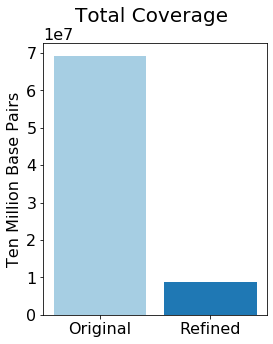

In [4]:
print("original prediction has a total coverage of", original_bed.total_coverage(), "bp")
print("refined prediction has a total coverage of", refined_bed.total_coverage(), "bp")
matplotlib.rcParams.update({'font.size': 16})
fig = plt.figure(figsize=(4, 5))
plt.bar(np.array([0, 0.3]), 
        np.array([original_bed.total_coverage(), refined_bed.total_coverage()]), 
        width = 0.25,
        align='center',
        color = ["#A6CEE3", "#1F78B4"])
plt.xticks(np.array([0, 0.3]), np.array(["Original", "Refined"]))
fig.suptitle('Total Coverage', fontsize=20)
plt.ylabel('Ten Million Base Pairs', fontsize=16)


a total of 224694 tss snps
original prediction has 25675 overlap with tss snps
refined prediction has 18236 overlap with tss snps


Text(0, 0.5, 'Count')

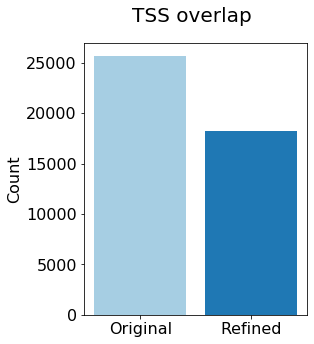

In [5]:
#compare tss overlap
tss_snps = pybedtools.BedTool("refTSS_v3.1_human_coordinate.hg38.bed")
print("a total of", tss_snps.count(), "tss snps")
print("original prediction has", original_bed.intersect(tss_snps).count(), "overlap with tss snps")
print("refined prediction has", refined_bed.intersect(tss_snps).count(), "overlap with tss snps")

fig = plt.figure(figsize=(4, 5))
plt.bar(np.array([0, 0.3]), 
        np.array([original_bed.intersect(tss_snps).count(), 
                  refined_bed.intersect(tss_snps).count()]), 
        width = 0.25,
        color = ["#A6CEE3", "#1F78B4"])
plt.xticks(np.array([0, 0.3]), np.array(["Original", "Refined"]))
fig.suptitle('TSS overlap', fontsize=20)
plt.ylabel('Count', fontsize=16)


In [6]:
phastCons = pyBigWig.open("./encode/dev/hg38.phastCons100way.bw")

original_phastCons = [float(phastCons.stats(x.chrom, x.start, x.stop)[0] or 0) for x in original_bed]
refined_pahstCons = [float(phastCons.stats(x.chrom, x.start, x.stop)[0] or 0) for x in refined_bed]

original_phastCons = np.nan_to_num(np.array(original_phastCons))
refined_pahstCons = np.nan_to_num(np.array(refined_pahstCons))

print("original prediction phastCons score is", np.median(original_phastCons))
print("refined prediction phastCons score is", np.median(refined_pahstCons))

original prediction phastCons score is 0.09216967104412493
refined prediction phastCons score is 0.11769781306605129


0.00e+00
0.00e+00


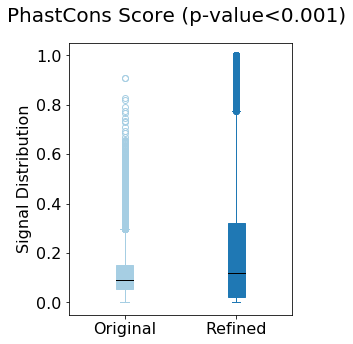

In [35]:
t, p = f_oneway(original_phastCons, refined_pahstCons)
print('{:.2e}'.format(p))

t, p = ttest_ind(original_phastCons, refined_pahstCons)
print('{:.2e}'.format(p))

# fig = plt.figure(figsize=(4, 5))
# box = plt.boxplot(np.array([np.array(original_phastCons), 
#                             np.array(refined_pahstCons)]), 
#                   labels=np.array(["Original", "Refined"]),
#                   boxprops=dict(color="#A6CEE3"),
#                   patch_artist=True, notch=True)
# fig.suptitle('PhastCons Score (p-value=' + str(p) + ")", fontsize=20)
# plt.ylabel('Signal Distribution', fontsize=16)

# colors = ["#A6CEE3", "#1F78B4"]

# plt.show();

fig = plt.figure(figsize=(4, 5))
c = "#A6CEE3"
box1 = plt.boxplot(np.array(original_phastCons), positions=[1], patch_artist=True,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c))
plt.setp(box1["medians"], color="black")

c2 = "#1F78B4"
box1 = plt.boxplot(np.array(refined_pahstCons), 
                   positions=[2],
                   patch_artist=True)
for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
        plt.setp(box1[item], color=c2)
plt.setp(box1["boxes"], facecolor=c2)
plt.setp(box1["medians"], color="black")
plt.setp(box1["fliers"], markeredgecolor=c2)
plt.xticks([1,2], [1,2,3])
plt.ylabel('Signal Distribution', fontsize=16)
fig.suptitle('PhastCons Score (p-value<0.001)', fontsize=20)
plt.xticks([1, 2], ['Original', 'Refined'])
plt.show();

# fig = plt.figure(figsize=(4, 5))
# plt.bar(np.array(["Original", "Refined"]), np.array([np.sum(original_phastCons), np.sum(refined_pahstCons)]))
# fig.suptitle('PhastCons Score', fontsize=20)
# plt.ylabel('Total Signal', fontsize=16)

In [8]:
#hg19 genome lift over
liftOver = "~/liftOver "
hg38_original = args.out_dir + args.cell_name + ".all.prediction_pos_regions.50.merged.bed "
hg38_2_hg19_chain = "~/hg38ToHg19.over.chain "
hg19_lifted = args.out_dir + args.cell_name + ".all.prediction_pos_regions.50.merged.hg19.lifted.bed "
hg19_unlift = args.out_dir + args.cell_name + ".all.prediction_pos_regions.50.merged.hg19.unlift.bed "
os.system(liftOver + hg38_original + hg38_2_hg19_chain + hg19_lifted + hg19_unlift)

liftOver = "~/liftOver "
hg38_original = args.out_dir + args.cell_name + ".all.prediction_pos_regions.50.filtered.bed "
hg38_2_hg19_chain = "~/hg38ToHg19.over.chain "
hg19_lifted = args.out_dir + args.cell_name + ".all.prediction_pos_regions.50.filtered.hg19.lifted.bed "
hg19_unlift = args.out_dir + args.cell_name + ".all.prediction_pos_regions.50.filtered.hg19.unlift.bed "
os.system(liftOver + hg38_original + hg38_2_hg19_chain + hg19_lifted + hg19_unlift)

0

In [9]:
#load in original bed from prediction
original_bed = pybedtools.BedTool(args.out_dir + args.cell_name + ".all.prediction_pos_regions.50.merged.hg19.lifted.bed")

#load in bed refined by grad cam
refined_bed = pybedtools.BedTool(args.out_dir + args.cell_name + ".all.prediction_pos_regions.50.filtered.hg19.lifted.bed")

In [10]:
#ASD summary statistics
ASD_snps = pybedtools.BedTool("./GWAS_catalog/linked_snps/Autism_spectrum_disorder")
print("a total of", ASD_snps.count(), "ASD snps")
print("original prediction has", original_bed.intersect(ASD_snps).count(), "overlap with ASD snps")
print("refined prediction has", refined_bed.intersect(ASD_snps).count(), "overlap with ASD snps")

a total of 4608 ASD snps
original prediction has 122 overlap with ASD snps
refined prediction has 24 overlap with ASD snps


In [11]:
#Bipolar_disorder summary statistics
Bipolar_disorder_snps = pybedtools.BedTool("./GWAS_catalog/linked_snps/Bipolar_disorder")
print("a total of", Bipolar_disorder_snps.count(), "Bipolar Disorder snps")
print("original prediction has", original_bed.intersect(Bipolar_disorder_snps).count(), "overlap with Bipolar Disorder snps")
print("refined prediction has", refined_bed.intersect(Bipolar_disorder_snps).count(), "overlap with Bipolar Disorder snps")

a total of 30773 Bipolar Disorder snps
original prediction has 898 overlap with Bipolar Disorder snps
refined prediction has 113 overlap with Bipolar Disorder snps


In [12]:
#Schizophrenia summary statistics
Schizophrenia_snps = pybedtools.BedTool("./GWAS_catalog/linked_snps/Schizophrenia")
print("a total of", Schizophrenia_snps.count(), "Schizophrenia snps")
print("original prediction has", original_bed.intersect(Schizophrenia_snps).count(), "overlap with Schizophrenia snps")
print("refined prediction has", refined_bed.intersect(Schizophrenia_snps).count(), "overlap with Schizophrenia snps")

a total of 128641 Schizophrenia snps
original prediction has 3812 overlap with Schizophrenia snps
refined prediction has 513 overlap with Schizophrenia snps
